In [1]:
import numpy as np
from pathlib import Path
import pandas as pd
from sys import platform
import os
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.signal import medfilt
sns.set_style('ticks')
%matplotlib inline

In [2]:
vol_file = Path('../Voltron_data/Voltron_Log_DRN_Exp.csv')
dat_xls_file = pd.read_csv(vol_file, index_col=0)
dat_xls_file['folder'] = dat_xls_file['folder'].apply(lambda x: f'{x:0>8}')
# using Path to handle switches filesystems
if platform == "linux" or platform == "linux2":
    dir_folder = Path('/nrs/ahrens/Ziqiang/Takashi_DRN_project/ProcessedData/')
elif platform == 'win32':
    dir_folder = Path('U:\\Takashi') # put folder for windows system

## Detecting session with valid swim

In [3]:
from swim_dat import *

In [4]:
# remove figures in the swim_power folder if any
import glob
if not os.path.isdir('swim_power'):
    os.mkdir('swim_power')
files = glob.glob('swim_power/*.png')
for f in files:
    os.remove(f)
plt.close('all')
valid_swim_list = []
for index, row in dat_xls_file.iterrows():
    valid_swim_list.append(valid_swim(row, sig_thres=0.5, isplot=True))

03152018 Fish1-1: average swim difference significance: 0.61
03152018 Fish4-1: average swim difference significance: 0.7
03152018 Fish4-2: average swim difference significance: 0.87
04052018 Fish4-1: average swim difference significance: 0.6
04052018 Fish4-2: average swim difference significance: 0.55
04122018 Fish2-1: average swim difference significance: 0.88
04122018 Fish2-2: average swim difference significance: 0.54
04122018 Fish4-1: average swim difference significance: 0.64
04192018 Fish1-1: average swim difference significance: 0.95
04192018 Fish1-2: average swim difference significance: 0.51
04192018 Fish2-2: average swim difference significance: 0.9
07122018 Fish1-1: average swim difference significance: 0.52
07122018 Fish1-2: average swim difference significance: 0.52
07122018 Fish2-2: average swim difference significance: 0.58
07262018 Fish2-1: average swim difference significance: 0.72
07262018 Fish2-2: average swim difference significance: 0.51
10182018 Fish2-1: average s

In [5]:
swim_xls_file = dat_xls_file[valid_swim_list]

In [6]:
swim_xls_file.to_csv('analysis_sections_based_on_swim_pattern.csv')

In [7]:
row = swim_xls_file.iloc[-1]

In [8]:
row

folder                            01312019
fish                               Fish4-2
task              Optovin+Gain adadptation
area                                 Raphe
swim                                  True
pixeldenoise                          True
registration                          True
detrend                               True
localdenoise                          True
demix                                 True
voltr                                 True
spikes                                True
subvolt                               True
FineTune                             False
dataToAnalysis                        True
rootDir               /nrs/ahrens/Takashi/
Name: 94, dtype: object

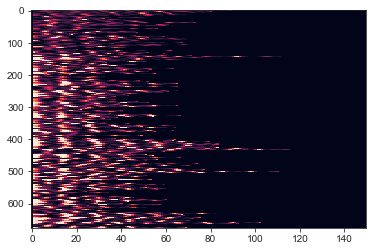

In [9]:
folder = row['folder']
fish = row['fish']
task_type = row['task']
dat_dir = dir_folder/f'{folder}/{fish}/Data/'
swim_dir = dir_folder/f'{folder}/{fish}/swim/'
frame_stimParams = np.load(swim_dir/'frame_stimParams.npy')
frame_swim_tcourse = np.load(swim_dir/'frame_swim_tcourse_series.npy')
rawdata = np.load(swim_dir/"rawdata.npy")[()]
swimdata = np.load(swim_dir/"swimdata.npy")[()]
reclen=len(swimdata['fltCh1'])
frame_tcourse=np.zeros((reclen,))
frame=np.where(np.diff((rawdata['ch3']>3).astype('int'))==1)[0]
for t in range(len(frame)-1):
    frame_tcourse[frame[t]:frame[t+1]]=t
swim_starts = frame_tcourse[np.where(swimdata['swimStartT']>0)[0]].astype('int')-1
swim_ends = frame_tcourse[np.where(swimdata['swimEndT']>0)[0]].astype('int')
swim_ends   = swim_ends[((swim_starts>50) & (swim_starts<(frame_swim_tcourse.shape[1]-250)))]
swim_starts = swim_starts[((swim_starts>50) & (swim_starts<(frame_swim_tcourse.shape[1]-250)))]

r_swim=np.empty((len(swim_starts),300))
r_swim[:] = 0 #np.nan
visu=np.empty((len(swim_starts),300))
visu[:] = 0 #np.nan

l_swim=np.empty((len(swim_starts),300))
l_swim[:] = 0 #np.nan

ave_swim_len = np.zeros(len(swim_starts))

for i in range(len(swim_starts)):
    swim_len = swim_ends[i] - swim_starts[i]
    if swim_len>250:
        swim_len = 250
    ave_swim_len[i] = swim_len
    r_swim[i,:swim_len+50]=frame_swim_tcourse[2,(swim_starts[i]-50):(swim_starts[i]+swim_len)]*100000
    l_swim[i,:swim_len+50]=frame_swim_tcourse[1,(swim_starts[i]-50):(swim_starts[i]+swim_len)]*100000
    visu[i,:swim_len+50]=-frame_stimParams[0,(swim_starts[i]-50):(swim_starts[i]+swim_len)]*10000

remove_ind = (r_swim.sum(axis=-1)==0) & (l_swim.sum(axis=-1)==0)
r_swim = r_swim[~remove_ind, :]
l_swim = l_swim[~remove_ind, :]
visu = visu[~remove_ind, :]

swim_starts = swim_starts[~remove_ind]
swim_ends = swim_ends[~remove_ind]

task_period = frame_stimParams[2,swim_starts].astype('int')
task_index   = frame_stimParams[2,:]+(frame_stimParams[3,:]-1)*4+(frame_stimParams[4,:]-1)*12;

if 'Optovin' in task_type:
    task_peroid = task_period + frame_stimParams[5,swim_starts+3]*task_period.max()

swim_task_index =  task_index[swim_starts]
swim_count  = np.zeros((len(swim_starts),))

ind_old=0
for s in range(len(swim_starts)):
    ind=swim_task_index[s]
    if (ind>ind_old):
        swim_count[s]=1
        ind_old=ind
    elif (ind==ind_old):
        swim_count[s]=swim_count[s-1]+1

plt.imshow(r_swim[:,50:200], aspect='auto', vmin=0, vmax=np.percentile(r_swim[:], 99))
plt.show()

### Swim behavioral variables
* number of burst (peaks)
* inter-burst-interval
* max power of peaks
* average power of peaks
* first peak time

In [10]:
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from scipy.signal import find_peaks
num_burst = np.zeros(r_swim.shape[0])
int_burst = np.zeros(r_swim.shape[0])
max_burst = np.zeros(r_swim.shape[0])
ave_burst = np.zeros(r_swim.shape[0])
fir_burst = np.zeros(r_swim.shape[0])

for n_burst in range(r_swim.shape[0]):
    rswim = r_swim[n_burst, 50:200]
    lswim = l_swim[n_burst, 50:200]
    swim_ = np.sqrt(rswim**2+lswim**2)
    peaks_ = find_peaks(swim_, prominence=0.5)[0] 
#     peaks_rl = rswim[peaks]>lswim[peaks]
#     peaks_r = peaks[peaks_rl]
#     peaks_l = peaks[~peaks_rl]
#     if rswim.max()>lswim.max():
#         peaks_ = peaks_r
#         swim_ = rswim
#     else:
#         peaks_ = peaks_l
#         swim_ = lswim   
    if len(peaks_) >1:
        num_burst[n_burst] = len(peaks_)/2
        int_burst[n_burst] = np.nanmean(np.diff(peaks_))
        max_burst[n_burst] = swim_.max()
        ave_burst[n_burst] = swim_[peaks_].mean()
        fir_burst[n_burst] = peaks_[0]
    
burst_list = [num_burst, int_burst, max_burst, ave_burst, fir_burst]
burst_list = np.asarray(burst_list)

# pca = PCA()
# pca.fit(burst_list.T)
# burst_pca = pca.transform(burst_list.T)

lda_ = LDA(n_components=2)
lda_.fit((burst_list.T)[task_peroid<3], task_peroid[task_peroid<3])

# plt.scatter(burst_pca[:, 0], burst_pca[:, 1], c=task_period[~remove_ind])
# plt.colorbar()
# plt.show()

LinearDiscriminantAnalysis(n_components=2, priors=None, shrinkage=None,
              solver='svd', store_covariance=False, tol=0.0001)

In [11]:
burst_pca = burst_list.T.dot(lda_.coef_.T)
burst_pca = burst_pca - np.mean(burst_pca)

In [12]:
# if 'Optovin' in task_type:
#     pain_stim_t = np.where(frame_stimParams[5]==1)[0]
#     # for each swim we find the time to the last pain stimulation
#     swim_pain_t = np.empty(len(swim_starts))
#     swim_pain_t[:] = np.inf
#     for n_, n_swim_start in enumerate(swim_starts):
#         if (pain_stim_t<n_swim_start).sum()>0:
#             # swim_pain_t[n_] = n_swim_start - pain_stim_t[pain_stim_t<n_swim_start][-1] 
#             swim_pain_t[n_] = np.abs(n_swim_start - pain_stim_t).min()
#     plt.scatter(burst_pca[task_period==1, 0], burst_pca[task_period==1, 1], c=swim_pain_t[task_period==1]/300)
#     plt.colorbar()
#     plt.show()

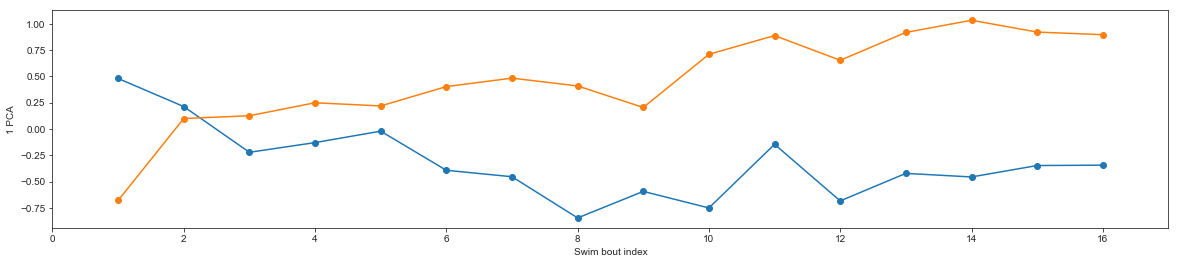

In [13]:
n_task = task_period.max().astype('int')

swim_task_index_ = (swim_task_index-1)%n_task+1
swim_bout_index_task = np.zeros(len(swim_task_index_)).astype('int')
swim_bout_index_task[0] = 1
for n_bout in range(len(swim_task_index_)-1):
    if swim_task_index_[n_bout] == swim_task_index_[n_bout-1]:
        swim_bout_index_task[n_bout] = swim_bout_index_task[n_bout-1]+1
    else:
        swim_bout_index_task[n_bout] = 1

swim_bout_index_task = swim_bout_index_task
swim_task_index_ = swim_task_index_

n_comp = 1

fig, ax = plt.subplots(1, n_comp, figsize=(20, 4))
if n_comp == 1:
    ax = [ax]
for nplot in range(n_comp):
    swim_var = burst_pca[:,nplot]
    max_burst_num = 16
    burst_ = np.empty((n_task, max_burst_num))
    burst_[:] = np.nan
    for task_ in range(n_task):
        for bout_ind in range(max_burst_num):
            ind_ = (swim_task_index_==task_+1) & (swim_bout_index_task == bout_ind+1)
            if ind_.sum()>0:
                burst_[task_, bout_ind] = swim_var[ind_].mean()
    ax[nplot].plot(np.arange(max_burst_num)+1, burst_.T, '-o')
    ax[nplot].set_xlabel('Swim bout index')
    ax[nplot].set_ylabel('%d PCA'%(nplot+1))
    ax[nplot].set_xlim([0, max_burst_num+1])

plt.show()

NameError: name 'swim_pain_t' is not defined

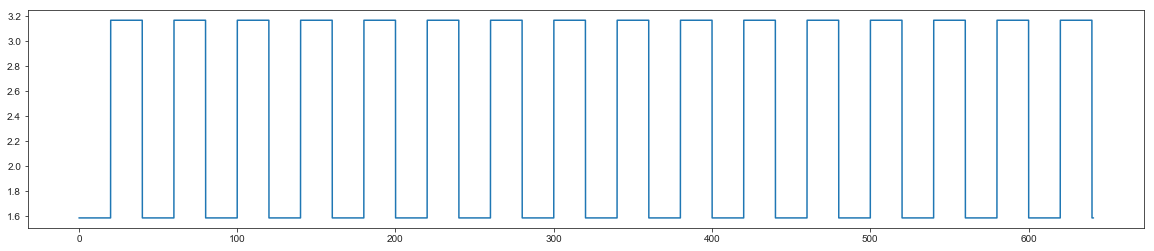

In [14]:
plt.figure(figsize=(20, 4))
n_comp = 0
len_t = len(frame_stimParams[2])
scale_ = burst_pca[:, n_comp].max()/frame_stimParams[2].max()
plt.plot(np.arange(len_t)/300, frame_stimParams[2]*scale_)
if 'Optovin' in task_type:
    swim_pain_t[np.isinf(swim_pain_t)]=swim_pain_t[~np.isinf(swim_pain_t)].max()
    plt.plot(np.arange(len_t)/300, frame_stimParams[5]*scale_)
    plt.scatter(swim_starts/300, burst_pca[:, n_comp], c=swim_pain_t/300)
    plt.colorbar()
else:
    plt.scatter(swim_starts/300, burst_pca[:, n_comp], c=swim_bout_index_task/300)
plt.xlim([0, len_t/300])
plt.show()

In [ ]:
plt.figure(figsize=(20, 4))
plt.plot(np.arange(len_t)/300, frame_stimParams[2]*scale_-scale_)
plt.plot(swim_starts[~remove_ind]/300, burst_pca[:, 0])
plt.xlim([0, len_t/300])
plt.show()

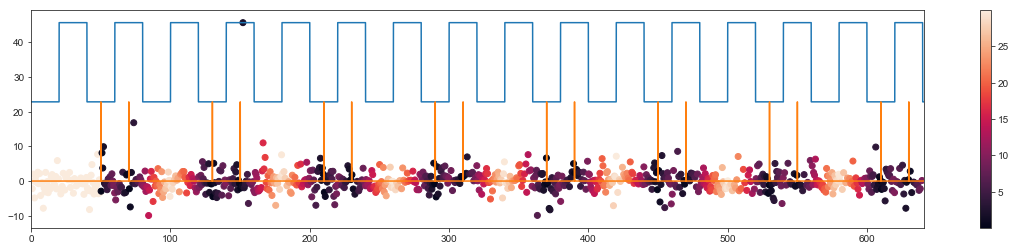

In [210]:
plt.figure(figsize=(20, 4))
len_t = len(frame_stimParams[2])
scale_ = burst_pca[:, 1].max()/frame_stimParams[2].max()
plt.plot(np.arange(len_t)/300, frame_stimParams[2]*scale_)
if 'Optovin' in task_type:
    swim_pain_t[np.isinf(swim_pain_t)]=swim_pain_t[~np.isinf(swim_pain_t)].max()
    plt.plot(np.arange(len_t)/300, frame_stimParams[5]*scale_)
    plt.scatter(swim_starts[~remove_ind]/300, burst_pca[:, 1], c=swim_pain_t[~remove_ind]/300)
    plt.colorbar()
else:
    plt.scatter(swim_starts[~remove_ind]/300, burst_pca[:, 1], c=swim_bout_index_task[~remove_ind])
plt.xlim([0, len_t/300])
plt.show()